# Viral Capsid Modeling with PyMembrane
This notebook demonstrates how to model a T=3 icosahedral viral capsid and compute its elastic energy using the [PyMembrane](https://github.com/fdmatoz/PyMembrane) package.

## Package Installation

In [ ]:
%cd /content/
!ls
!rm -rf PyMembrane/

/content
faces.inp  sample_data	vertices.inp


In [ ]:
# Install and setup (run only once)
!git clone https://github.com/fdmatoz/PyMembrane.git

Cloning into 'PyMembrane'...
remote: Enumerating objects: 9112, done.
remote: Counting objects: 100% (6999/6999), done.
remote: Compressing objects: 100% (995/995), done.
remote: Total 9112 (delta 6686), reused 6075 (delta 6002), pack-reused 2113 (from 1)
Receiving objects: 100% (9112/9112), 52.83 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (7954/7954), done.
Updating files: 100% (1135/1135), done.


In [ ]:
%cd /content/PyMembrane/pymembrane/cppmodule/external
!rm -rf pybind11
!git clone https://github.com/pybind/pybind11.git pybind11

/content/PyMembrane/pymembrane/cppmodule/external
Cloning into 'pybind11'...
remote: Enumerating objects: 30750, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 30750 (delta 75), reused 58 (delta 43), pack-reused 30600 (from 4)
Receiving objects: 100% (30750/30750), 12.16 MiB | 11.80 MiB/s, done.
Resolving deltas: 100% (21843/21843), done.


In [ ]:
%cd /content/PyMembrane/
!python setup.py install

/content/PyMembrane
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()

running build
running build_py
creating build/lib/pymembrane
copying pymembrane/__init__.py -> build/lib/pymembrane
creating build/lib/pymembrane/cppmodule
copying pymembrane/cppmodule/__init__.py -> build/lib/pymembrane/cppmodule
running install_lib
creating /usr/local/lib/python3.11/dist-packages/pymembrane
creating /usr/local/lib/python3.11/dist-packages/pymembrane/cppmodule
c

## Load T=3 Icosahedral Capsid Mesh

In [ ]:
%cd /content/
import pymembrane as pm
import numpy as np

/content


ModuleNotFoundError: No module named 'pymembrane'

In [ ]:
vertices = """0	-0.6881909602355872	0.49999999999999956	0.4253254041760197	1
1	-1.1102230246251565e-16	-4.440892098500626e-16	0.9510565162951536	1
2	0.2628655560595671	0.8090169943749475	0.4253254041760197	1
3	-0.6881909602355871	-0.4999999999999998	0.42532540417602016	1
4	0.26286555605956696	-0.809016994374947	0.42532540417602016	1
5	0.8506508083520401	4.440892098500626e-16	0.42532540417602016	1
6	0.	2.7755575615628914e-16	-0.9510565162951539	1
7	0.6881909602355867	-0.49999999999999983	-0.42532540417602016	1
8	-0.26286555605956696	-0.8090169943749475	-0.42532540417602016	1
9	0.6881909602355867	0.5	-0.4253254041760204	1
10	-0.2628655560595674	0.809016994374947	-0.42532540417601994	1
11	-0.8506508083520403	-4.440892098500626e-16	-0.42532540417601994	1"""

faces = """0	0	1	2	1	1
1	0	1	3	-1	1
2	0	2	10	1	1
3	0	3	11	-1	1
4	0	10	11	1	1
5	1	2	5	-1	1
6	1	3	4	1	1
7	1	4	5	1	1
8	2	5	9	1	1
9	2	9	10	1	1
10	3	4	8	-1	1
11	3	8	11	-1	1
12	4	5	7	-1	1
13	4	7	8	-1	1
14	5	7	9	1	1
15	6	7	8	1	1
16	6	7	9	-1	1
17	6	8	11	1	1
18	6	9	10	-1	1
19	6	10	11	-1	1"""

with open("vertices.inp", "w") as f:
    f.write(vertices)
with open("faces.inp", "w") as f:
    f.write(faces)

In [ ]:
box = pm.Box(40.0, 40.0, 40.0)
system = pm.System(box)

# Load the vertex and face files (ensure these are in the working directory)
vertex_file = 'vertices.inp'
face_file = 'faces.inp'
system.read_mesh_from_files(files={'vertices':vertex_file, 'faces':face_file})

dump = system.dumper
dump.vtk("initial mesh", False)

evolver = pm.Evolver(system)

Mesh
 Numvertices  12
 NumFaces  20
 NumEdges  30
 NumHEdges  60


## Define Elastic Properties and Compute Energy

In [ ]:
evolver.add_force("Mesh>Harmonic", {"k": {"0": str(10.0)},
                                    "l0": {"0": str(1.0)}})

evolver.add_force("Mesh>Bending>Dihedral", {"kappa":{"0": str(10.0)}})
evolver.add_force("Mesh>Limit", {"lmin": {"0": str(0.7)},
                                 "lmax": {"0": str(1.3)}})

evolver.add_integrator("Mesh>MonteCarlo>vertex>move", {"dr":"0.008", "spherical_move": "false"})
evolver.add_integrator("Mesh>MonteCarlo>edge>swap", {"every step": str(100)})

In [ ]:
compute = system.compute
edge_lengths = compute.edge_lengths()
print(edge_lengths)

[1.0000000000000002, 1.0000000000000007, 1.0000000000000007, 0.9999999999999993, 0.9999999999999998, 1.0000000000000002, 0.9999999999999997, 0.9999999999999998, 0.9999999999999998, 0.9999999999999999, 1.0000000000000002, 0.9999999999999996, 1.0000000000000004, 0.9999999999999993, 1.0, 1.0000000000000002, 1.0, 1.0000000000000002, 1.0000000000000004, 1.0000000000000004, 0.9999999999999998, 1.0, 1.0000000000000004, 1.0, 0.9999999999999998, 1.0, 1.0000000000000002, 0.9999999999999997, 1.0000000000000004, 0.9999999999999998]


In [ ]:
snapshots = 10
run_steps = 10000
## Compute the initial energy
mc_energy = snapshots*[None]
mc_energy[0] = compute.energy(evolver)['edges']/system.Numedges
print("[Initial] energy = {}".format(mc_energy[0]))
dump.vtk("sphere_t0")
for snapshot in range(1, snapshots):
    for ti, temperature in enumerate([10^-3,10^-5,10^-7,0]): #using heating and cooling cycles
        evolver.set_global_temperature(str(temperature))
        evolver.evolveMC(steps=run_steps)
        dump.vtk("sphere_t" + str(snapshot*run_steps))
        mc_energy[snapshot] =  compute.energy(evolver)['edges']/system.Numedges
        print("[{}] energy = {}".format(snapshot,  mc_energy[snapshot]))

dump.vtk('final_mesh')

[Initial] energy = 2.546440075000699
[1] energy = 2.9345087724198033
[1] energy = 3.292577177480953
[1] energy = 3.614939323334214
[1] energy = 2.5464405351235446
[2] energy = 3.040072150280392
[2] energy = 3.024854185766078
[2] energy = 3.583729483794802
[2] energy = 2.546440573778573
[3] energy = 3.078695094481598
[3] energy = 3.1688631393491877
[3] energy = 2.8638051353280947
[3] energy = 2.5464405933537946
[4] energy = 3.8274912110617842
[4] energy = 3.328306511370867
[4] energy = 3.2959667226377274
[4] energy = 2.5464407719157807
[5] energy = 2.8981929524634253
[5] energy = 4.048295840964829
[5] energy = 3.0691735623830243
[5] energy = 2.54644056070529
[6] energy = 3.374054149003848
[6] energy = 3.469583440164996
[6] energy = 4.199014335317726
[6] energy = 2.5464409244977957
[7] energy = 3.012076694847315
[7] energy = 3.1037032583515143
[7] energy = 3.0229753125155763
[7] energy = 2.5464403208509143
[8] energy = 3.1181434133374517
[8] energy = 3.094814779371889
[8] energy = 3.2428

In [ ]:
# from google.colab import files
# files.download('minimization_t0.vtp')
# files.download('minimization_t0_edges.vtp')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualization
To visualize the capsid structure, export the mesh and use a tool like [ParaView](https://www.paraview.org/).

In [ ]:
!pip install pyvista
!pip install matplotlib

In [ ]:
!ls

 faces.inp		   sphere_t10000.vtp	     sphere_t60000.vtp
 final_mesh_edges.vtp	   sphere_t20000_edges.vtp   sphere_t70000_edges.vtp
 final_mesh.vtp		   sphere_t20000.vtp	     sphere_t70000.vtp
'initial mesh_edges.vtp'   sphere_t30000_edges.vtp   sphere_t80000_edges.vtp
'initial mesh.vtp'	   sphere_t30000.vtp	     sphere_t80000.vtp
 PyMembrane		   sphere_t40000_edges.vtp   sphere_t90000_edges.vtp
 sample_data		   sphere_t40000.vtp	     sphere_t90000.vtp
 sphere_t0_edges.vtp	   sphere_t50000_edges.vtp   vertices.inp
 sphere_t0.vtp		   sphere_t50000.vtp
 sphere_t10000_edges.vtp   sphere_t60000_edges.vtp


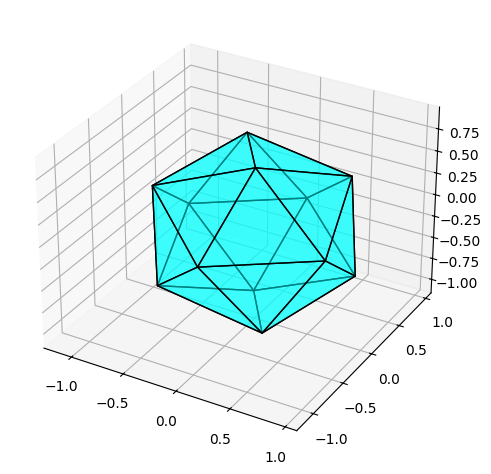

In [ ]:
import pyvista as pv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# mesh = pv.Sphere()
mesh = pv.read('sphere_t90000.vtp')

points = mesh.points
faces = mesh.faces.reshape((-1, 4))[:, 1:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

poly3d = [points[face] for face in faces]
collection = Poly3DCollection(poly3d, facecolor='cyan', edgecolor='k', alpha=0.5)
ax.add_collection3d(collection)

scale = points.flatten()
ax.auto_scale_xyz(scale, scale, scale)

plt.tight_layout()
plt.show()

In [ ]:
# mesh = examples.download_bunny_coarse()
# cpos = [(0.2, 0.3, 0.9), (0, 0, 0), (0, 1, 0)]
# mesh.plot(cpos=cpos, show_edges=True, color=True, interactive=False)

## Comparison with Arbitrary Geometry
Repeat the same steps above using a different mesh file (with the same number of triangular subunits) and compare the resulting elastic energy.